# MINE Mutual Information Estimation in Zero-Dispersion Optical Channel 

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Using the MINE mutual information estimator [1] to compute the achievable information rate (AIR) of the channel

[1] M. Belghazi, A. Baratin, S. Rajeswar, S. Ozair, Y. Bengio, A. Courville, and R. D Hjelm, "MINE: Mutual information
neural estimation," _Proc. International Conference on Machine Learning (ICML)_, preprint available at https://arxiv.org/abs/1801.04062, 2018

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

%matplotlib inline 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [2] is given by an iterative application of the equation
$$
\tilde{t}_{k+1} = \tilde{t}_k\exp\left(\jmath\frac{L}{K}\gamma|\tilde{t}_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $\tilde{t}_0=t$ is the channel input (the modulated, complex symbols) and $r=\tilde{t}_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel. Usually $K=50$ gives a good approximation.

Here, we specify a 16-QAM to communicate over the channel.

[2] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," _Proc. European Conference on Optical Communications (ECOC)_, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 10 # number of steps used in the channel model


constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6])}

def simulate_channel(x, Pin, constellation):      
    # modulate 16-qam
    assert all(x >= 0)
    assert all(x < len(constellation))
    # input power (in W), normalize to input power
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
    modulated = constellation[x] * norm_factor

    # noise variance per step    
    sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

    # channel model
    temp = np.array(modulated, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return modulated,temp

We consider 16-QAM transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [3]:
length_plot = 4000

def plot_constellation(Pin, constellation_name):
    constellation = constellations[constellation_name]
        
    t = np.random.randint(len(constellation),size=length_plot)
    _,r = simulate_channel(t, Pin, constellation)

    plt.figure(figsize=(12,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.subplot(1,2,1)
    r_tx = constellation[range(len(constellation))]
    plt.scatter(np.real(r_tx), np.imag(r_tx), c=range(len(constellation)), marker='o', s=200, cmap='tab20')
    plt.xticks(())
    plt.yticks(())
    plt.axis('equal')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.title('Transmitted constellation')
    
    plt.subplot(1,2,2)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='tab20',s=4)
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation ($L = %d$\,km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    #plt.savefig('%s_received_zd_%1.2f.pdf' % (constellation_name.replace('-','_'),Pin),bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, \
                                 Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')), \
                                 constellation_name = widgets.RadioButtons(options=['16-QAM','16-APSK'], value='16-QAM',continuous_update=False,description='Constellation'))


output = interactive_update.children[-1]
output.layout.height = '400px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

In [20]:
class Variational_Function(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2):
        super(Variational_Function, self).__init__()
        
        # Linear function, 4 input neurons (real and imaginary part of transmit signal, real and imaginary part of receive signal)        
        self.fc1 = nn.Linear(4, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
    
        # Soft-sign
        self.softsign = nn.Softsign()
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(p=0)
        
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer generating a scalar
        self.fc3 = nn.Linear(hidden_neurons_2, 1)
        
        # initialize weights of layers
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer        
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer        
        out = self.activation_function(out)
        
        # Linear function, output layer
        #out = 60.0*self.softsign(self.fc3(out))
        #out = 50.0 - self.relu(self.fc3(out))
        out = self.fc3(out)
                
        return out

In [ ]:
Pin = 2
constellation = constellations['16-APSK']

hidden_neurons_1 = 400
hidden_neurons_2 = 400

# Generate variational function
model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
model.to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)  

num_epochs = 150
batches_per_epoch = 1000

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(200, 10000, num=num_epochs, dtype=int)

ma_et = 0.0

for epoch in range(num_epochs):
    for step in range(batches_per_epoch):
        
        ti = np.random.randint(len(constellation), size=batch_size_per_epoch[epoch])
        t,r = simulate_channel(ti, Pin, constellation)

        ti = np.random.randint(len(constellation), size=batch_size_per_epoch[epoch])
        _,rtilde = simulate_channel(ti, Pin, constellation)
        
        
        model.train()
                
        # generate input to first call of the variational function
        input_1 = np.vstack( (np.real(t), np.imag(t), np.real(r), np.imag(r)) ).transpose()
        torch_in1 = torch.from_numpy(input_1).float().to(device)
        
        # generate input to second call of the variational function
        input_2 = np.vstack( (np.real(t), np.imag(t), np.real(rtilde), np.imag(rtilde)) ).transpose()
        torch_in2 = torch.from_numpy(input_2).float().to(device)
        
        # apply the variational function
        out_1 = model(torch_in1)
        out_2 = model(torch_in2)
        
        
        # loss function. Attenation, put a minus sign as we want to maximize        
        #loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))
        #loss = -torch.mean(out_1) + torch.logsumexp(out_2 * np.log(2.0), 0) / np.log(2.0)  #log(torch.mean(torch.exp(out_2)))

        # biased-corrected estimator with moving average
        tmp = torch.exp(out_2)
        ma_et = (1.0-0.05)*ma_et + 0.05*torch.mean(tmp.detach())        
        #avg_et = torch.mean(tmp).detach()
        #loss = -torch.mean(out_1) + (1/avg_et).detach() * torch.mean(torch.exp(out_2))        
        #loss = -torch.mean(out_1) + (1/avg_et).detach() * torch.mean(out_2 * tmp.detach())        
        loss = -torch.mean(out_1) + (1/ma_et.mean()).detach() * torch.mean(torch.exp(out_2))        
        #loss = -torch.mean(out_1) + (1/ma_et.mean()).detach() * torch.mean(tmp.detach() * out_2)
              
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
            
    #print(loss)
    model.eval()
    ti = np.random.randint(len(constellation),size=10000)
    t,r = simulate_channel(ti, Pin, constellation)
        
    rtilde = r[np.random.permutation(len(r))]
        
    # generate input to first call of the variational function
    input_1 = np.vstack( (np.real(t), np.imag(t), np.real(r), np.imag(r)) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)
        
    # generate input to second call of the variational function
    input_2 = np.vstack( (np.real(t), np.imag(t), np.real(rtilde), np.imag(rtilde)) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)
        
    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)
        
    # loss function. Attenation, put a minus sign as we want to maximize    
    MI_eval = torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))    
    print('Epoch %d: current MI estimate is %1.3f bit/channel use' % (epoch, MI_eval.cpu().detach().numpy()) )




Epoch 0: current MI estimate is -0.000 bit/channel use
Epoch 1: current MI estimate is 0.000 bit/channel use
Epoch 2: current MI estimate is 0.117 bit/channel use
Epoch 3: current MI estimate is 0.137 bit/channel use
Epoch 4: current MI estimate is 0.145 bit/channel use
Epoch 5: current MI estimate is 0.145 bit/channel use
Epoch 6: current MI estimate is 0.147 bit/channel use
Epoch 7: current MI estimate is 0.155 bit/channel use
Epoch 8: current MI estimate is 0.166 bit/channel use
Epoch 9: current MI estimate is 0.211 bit/channel use
Epoch 10: current MI estimate is 0.660 bit/channel use
Epoch 11: current MI estimate is 0.813 bit/channel use
Epoch 12: current MI estimate is 0.922 bit/channel use
Epoch 13: current MI estimate is 1.020 bit/channel use
Epoch 14: current MI estimate is 1.046 bit/channel use
Epoch 15: current MI estimate is 1.143 bit/channel use
Epoch 16: current MI estimate is 1.333 bit/channel use
Epoch 17: current MI estimate is 1.624 bit/channel use
Epoch 18: current M

Now we train a GMM for each constellation point individually. We will use this one to compute the mutual information (and hence the performance of a transmission scheme) later

In [103]:
def MINE_getMI_OpticalZD(Pin, constellation):    
    hidden_neurons_1 = 256
    hidden_neurons_2 = 256

    # Generate variational function
    model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
    model.to(device)

    # Adam Optimizer
    optimizer = optim.Adam(model.parameters())  

    num_epochs = 150
    batches_per_epoch = 1000

    # increase batch size while learning from 100 up to 10000
    batch_size_per_epoch = np.linspace(100, 10000, num=num_epochs, dtype=int)

    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):

            ti = np.random.randint(len(constellation), size=batch_size_per_epoch[epoch])
            t,r = simulate_channel(ti, Pin, constellation)

            ti = np.random.randint(len(constellation), size=batch_size_per_epoch[epoch])
            _,rtilde = simulate_channel(ti, Pin, constellation)


            model.train()

            # generate input to first call of the variational function
            input_1 = np.vstack( (np.real(t), np.imag(t), np.real(r), np.imag(r)) ).transpose()
            torch_in1 = torch.from_numpy(input_1).float().to(device)

            # generate input to second call of the variational function
            input_2 = np.vstack( (np.real(t), np.imag(t), np.real(rtilde), np.imag(rtilde)) ).transpose()
            torch_in2 = torch.from_numpy(input_2).float().to(device)

            # apply the variational function
            out_1 = model(torch_in1)
            out_2 = model(torch_in2)


            # loss function. Attenation, put a minus sign as we want to maximize
            loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))

            # compute gradients
            loss.backward() 

            # carry out one optimization step with Adam
            optimizer.step()

            # reset gradients to zero
            optimizer.zero_grad()
        
    model.eval()
    ti = np.random.randint(len(constellation),size=100000)
    t,r = simulate_channel(ti, Pin, constellation)
    
    ti = np.random.randint(len(constellation),size=100000)
    _,rtilde = simulate_channel(ti, Pin, constellation)            
        
    # generate input to first call of the variational function
    input_1 = np.vstack( (np.real(t), np.imag(t), np.real(r), np.imag(r)) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)
        
    # generate input to second call of the variational function
    input_2 = np.vstack( (np.real(t), np.imag(t), np.real(rtilde), np.imag(rtilde)) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)
        
    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)
        
    # loss function. Attenation, put a minus sign as we want to maximize
    MI_eval = torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))
    return MI_eval.cpu().detach().numpy()

In [105]:
from ipywidgets import IntProgress
from IPython.display import display

num_elements = 15
Pin_range = np.linspace(-15,10, num_elements)


f = IntProgress(min=0, max=num_elements) # instantiate the bar
display(f) # display the bar

MI_ref = np.zeros(num_elements)
MI_MINE = np.zeros(num_elements)

for i,Pin in enumerate(Pin_range):    
    MI_MINE[i] = MINE_getMI_OpticalZD(Pin, constellations['16-APSK'])
    
    # increase progress bar
    f.value += 1

IntProgress(value=0, max=15)

KeyboardInterrupt: 

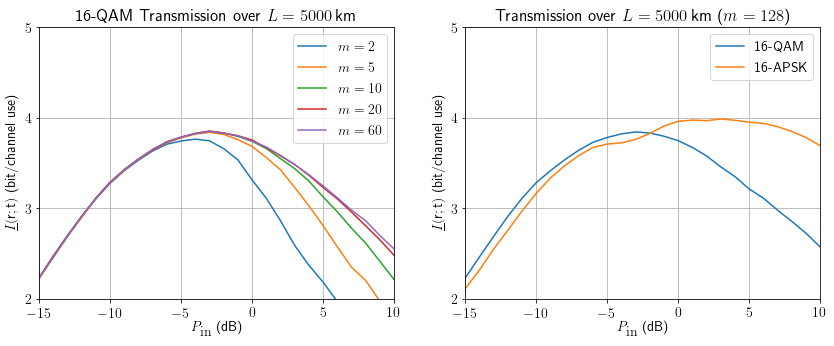

In [70]:
# plotting options 
import matplotlib
font = {'size'   : 15}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

plt.figure(figsize=(7,5))
plt.plot(esno_range, MI_MINE)
plt.xlim((-15,10))
plt.ylim((0,5))
plt.grid(True)
plt.title('MINE over the Optical Zero-Dispersion Channel');
plt.xlabel('$P_{\mathrm{in}}$ (dBm)')
plt.ylabel('$\\hat{I}(\mathsf{r};\mathsf{t})$ (bit/channel use)')

plt.savefig('MINE_OpticalZD.pdf',bbox_inches='tight')
#plt.savefig('MIestimates_GMM.pdf',bbox_inches='tight')